In [22]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

In [21]:
%matplotlib inline

# Module 15 Lab - Time Series

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Canvs.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")
# load whatever other libraries you need including models.py

This lab covers time series data.  The exact flow may look a little different from the ETL/EDA/Modeling sequence that we've become familiar with from linear models, but we will follow the same general process.  Complete each of the following according to the course notes in Module 15.

## 1: Load the data, cleaning and transforming if necessary.


In [76]:
df = pd.read_csv('https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/timeseries.csv')
# add the rest of your code below here


Let's look at the data

In [77]:
df.head()

,date,value
0,2019-01-01,64.51
1,2019-01-02,1.67
2,2019-01-03,84.41
3,2019-01-04,119.14
4,2019-01-05,20.78


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    180 non-null    object 
 1   value   180 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


Only 2 columns with dates and values. We have 180 observations. I'm going to rearrange the time format. Note all the observations have the same year.

In [79]:
days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [80]:
calendar = []

today = datetime(2018, 12, 31, 0, 0)
for _ in range(0, 180):
    today = today + timedelta(days=1)
    date = today.strftime("%m/%d/%y")
    day = days_of_the_week[today.weekday()]
    calendar.append((date, day))

It might be useful to look at the days of the week later. I'll concat them into our dataframe along with just the month and day

In [81]:

dates = pd.Series([i[0][:5] for i in calendar], name='date_trunc')
days = pd.Series([i[1] for i in calendar], name='day')
df = pd.concat([df, dates, days], axis=1)

Here is the adjusted dataframe

In [82]:
df

,date,value,date_trunc,day
0,2019-01-01,64.51,01/01,Tuesday
1,2019-01-02,1.67,01/02,Wednesday
2,2019-01-03,84.41,01/03,Thursday
3,2019-01-04,119.14,01/04,Friday
4,2019-01-05,20.78,01/05,Saturday
...,...,...,...,...
175,2019-06-25,178.84,06/25,Tuesday
176,2019-06-26,354.54,06/26,Wednesday
177,2019-06-27,279.00,06/27,Thursday
178,2019-06-28,286.76,06/28,Friday


Good enough for now. Let's move on to EDA.

## 2: Perform EDA on the time variable and describe what kind of time series (trend, seasonality, etc).

Time is an ordered variable, technically numeric but we wouldn't traditionally perform mathematical operations on time series data.

In [83]:
df['date'].describe()

count            180
unique           180
top       2019-01-01
freq               1
Name: date, dtype: object

Here are the head and tail of the dataframe once again

In [84]:
df

,date,value,date_trunc,day
0,2019-01-01,64.51,01/01,Tuesday
1,2019-01-02,1.67,01/02,Wednesday
2,2019-01-03,84.41,01/03,Thursday
3,2019-01-04,119.14,01/04,Friday
4,2019-01-05,20.78,01/05,Saturday
...,...,...,...,...
175,2019-06-25,178.84,06/25,Tuesday
176,2019-06-26,354.54,06/26,Wednesday
177,2019-06-27,279.00,06/27,Thursday
178,2019-06-28,286.76,06/28,Friday


As such, we can't really get a mean, median, or other usual summary statistics.

We see the date ranges we have are from Jan 1st 2019 to Jun 29th 2019, the first half of the year. Let's plot it to see what values we get for each date.

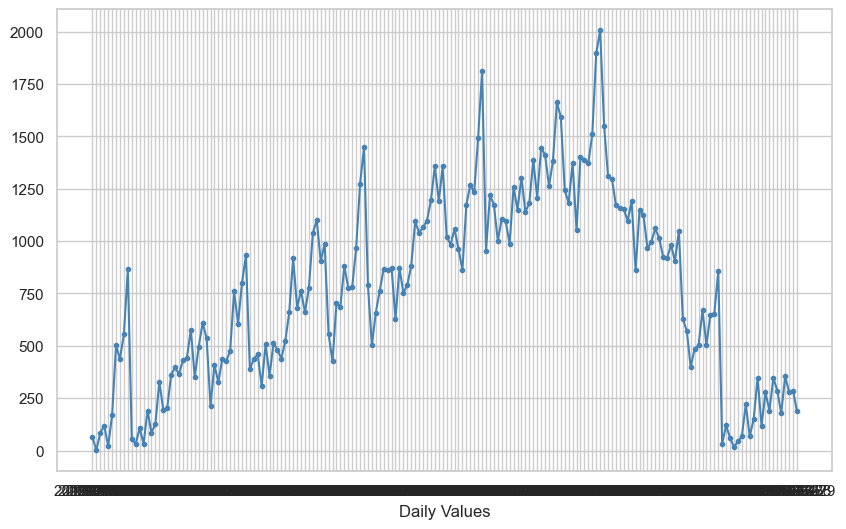

In [86]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

axes.plot(df["date"], df[ "value"], color="steelblue", marker=".")
axes.set_xlabel("Daily Values")

plt.show()

We definitely see a pattern here, we steadily increase until about 75% through the data, then start decreasing. Here is another plot only showing by month, which might be easier to read:

In [87]:
import matplotlib.dates as mdates

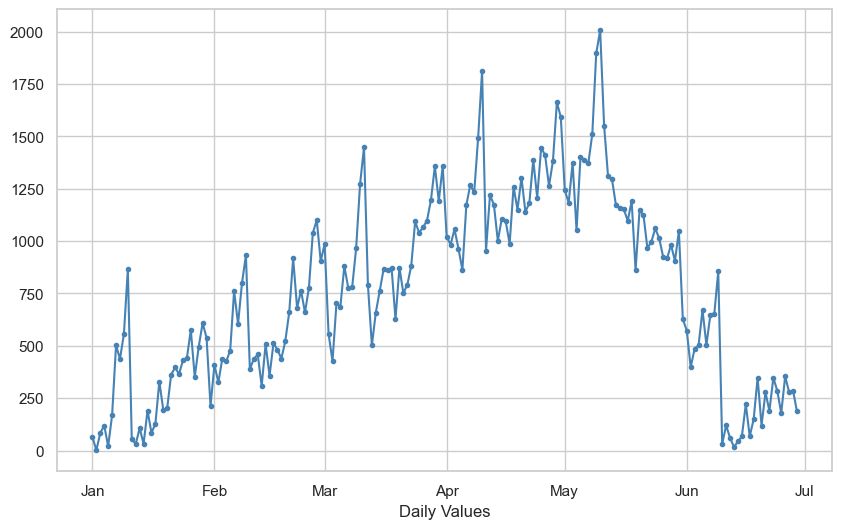

In [88]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

axes.xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b')
axes.xaxis.set_major_formatter(fmt)

axes.plot(df["date"], df[ "value"], color="steelblue", marker=".")
axes.set_xlabel("Daily Values")

plt.show()

A bit better. We see that values increase until beginning of May, then decrease afterwards, and rise a bit in Jun as well, following a sharp drop.

I'll consider this good enough for the purposes of our EDA. Let's move on to creating the models in the next step.

## 3: Create models with each of Simple Exponential Smoothing, Holts Trend Correction and Holts Winters Seasonality Adjustment. Choose an error (SSE, etc) and compare the three models. How are they different, and why?

## 4: Choose one of the models and find its optimal parameters (ie, α).

##  5: Finally, pick one of the models from above and forecast some future values.